# Semantic Segmentation

The main goal of this project is to tackle a problem of semantic segmentation, specifically the segmentation of road cracks.

Some code is already provided (mainly the data loading code). You can modify most of the code unless specifically stated that some section should not be changed.

In [ ]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import shutil
import random
random.seed(42) # DO NOT CHANGE THIS

# add more imports here

## Loading the data

Let's start by loading the data. You can find the dataset [here](https://drive.google.com/file/d/13L-Xe5gZPEg3kNWh4sl0uxoVM4C4OlYL/view?usp=share_link).

Download the zip file and upload it to your google drive.

Let's now mount the drive and access the folder where you saved the dataset.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# access the data
#datadir = '/content/drive/MyDrive/dataset.zip' # change this path to where you stored the dataset
#datadir = '/content/drive/MyDrive/Uni/4º Ano 2º Semestre/PAIA/dataset.zip'
datadir = '/content/drive/MyDrive/Uni/PAIA/dataset (1).zip'


# unzip dataset
shutil.unpack_archive(datadir)

In [ ]:
# DO NOT CHANGE THIS CELL
images_list = os.listdir('dataset/images')
random.shuffle(images_list)

train_list = images_list[:300]
val_list = images_list[300:350]
test_list = images_list[350:]

## Visualizing the data

In the following section, you can use the function ``` display_image_grid ``` to visualize the data.



In [ ]:
# note that you can use this function to visualize your model's predictions
def display_image_grid(images_filenames, images_directory='dataset', predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        # read image and convert to RGB
        image = cv2.imread(os.path.join(images_directory, 'images', image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # read mask
        mask = cv2.imread(os.path.join(images_directory, 'masks', image_filename), cv2.IMREAD_GRAYSCALE)
        mask[mask <= 127] = 0
        mask[mask > 127] = 1

        # plot
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, cmap='gray')

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, cmap='gray')
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()

    plt.tight_layout()
    plt.show()

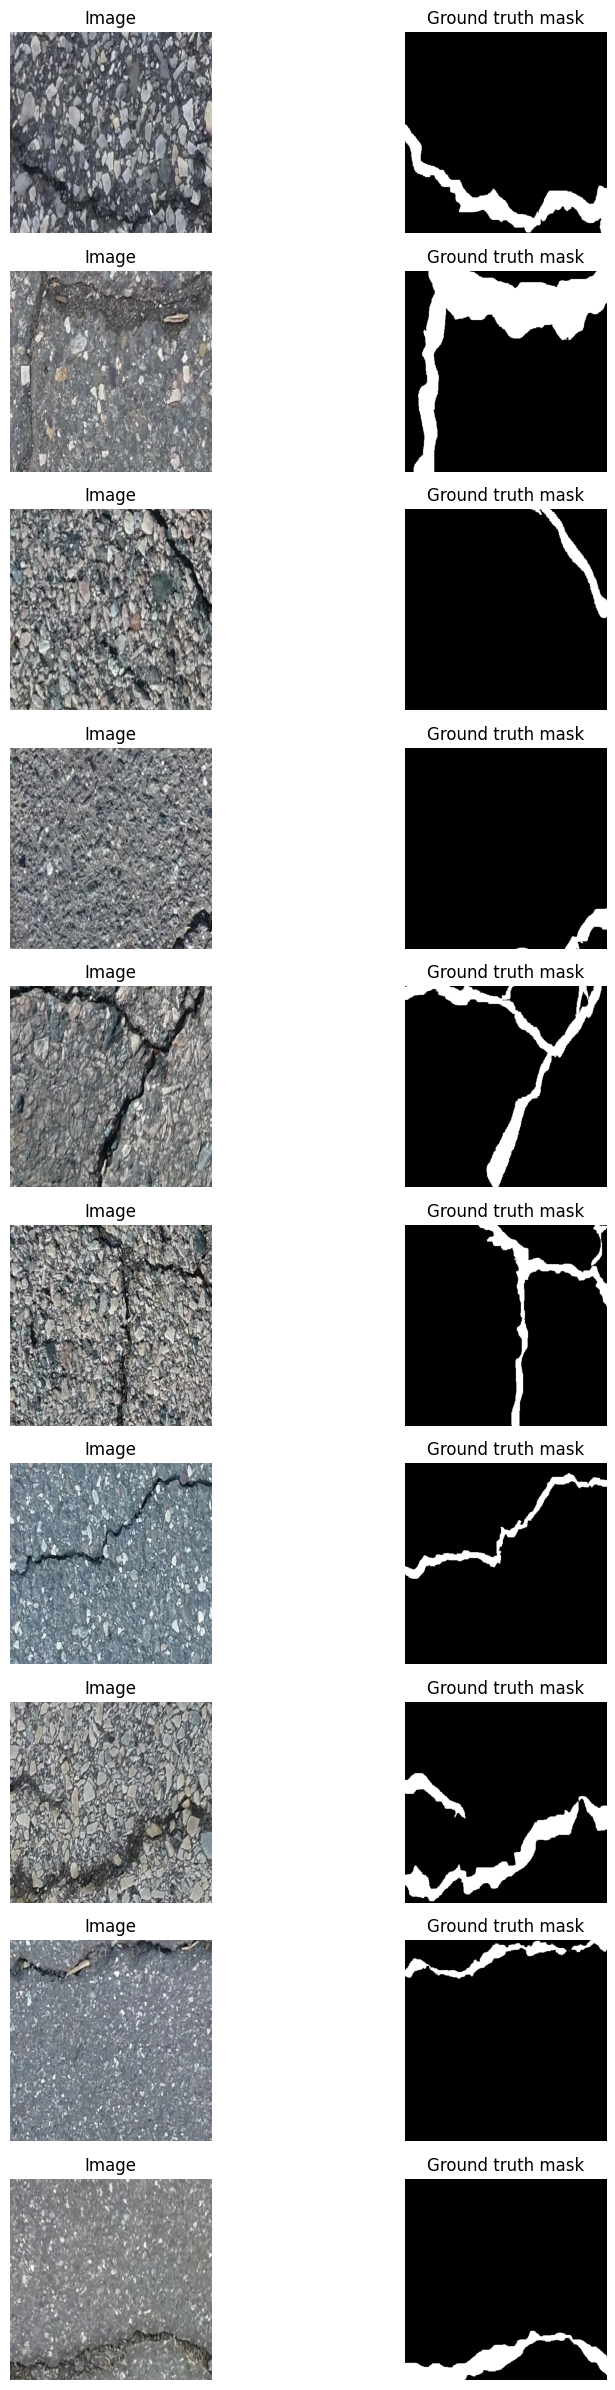

In [ ]:
display_image_grid(train_list[:10], 'dataset')

## Building the Dataset

In [ ]:
class RoadCracksDataset(Dataset):
    def __init__(self, images_list, images_directory='dataset', transform=None):
        self.images_list = images_list
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        image_filename = self.images_list[idx]
        image = cv2.imread(os.path.join(self.images_directory, 'images', image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(self.images_directory, 'masks', image_filename), cv2.IMREAD_GRAYSCALE)
        mask[mask <= 127] = 0
        mask[mask > 127] = 1

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask.to(torch.int64)

## Defining the hyperparameters and model

Some hyperparameters have already been defined. Feel free to experiment and change them as you see fit.

In [ ]:
# hyperparameters
nr_classes = 2 # this is a binary segmentation problem
batch_size = 8
num_workers = 2
epochs = 10
learning_rate = 1e-4

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# define transforms
transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
# feel free to add data augmentation if you see fit

In [ ]:
# build the dataset and dataloaders
# DO NOT CHANGE THIS CELL (particularly the shuffling)
train_dataset = RoadCracksDataset(train_list, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dataset = RoadCracksDataset(val_list, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

test_dataset = RoadCracksDataset(test_list, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Exercise 1

Finetune a pretrained segmentation model on the RoadCracks dataset using the standard cross entropy loss.

Measure the performance of your model **on the test set** in terms of:
*   pixel accuracy
*   Intersection over Union (IoU)

Plot some of the obtained segmentation results and compare them with the ground truth.




In [ ]:
### Write your code here ###
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms
from torch.optim import Adam
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

# load pretrained model (do not forget to change the number of classes)
weights = models.segmentation.FCN_ResNet101_Weights.DEFAULT
model = models.segmentation.fcn_resnet101(weights=weights)

#changes to 2 classes: crack and no crack
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))

# put model in GPU
model.to(device)

# define optimizer
optimizer = Adam(model.parameters(), learning_rate)

# define loss
criterion = nn.CrossEntropyLoss()

# train the model
for epoch in range(epochs):
        model.train()
        for images, masks in train_dataloader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            output = model(images)['out']
            loss = criterion(output, masks)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# measure the performance of your model
def pixel_accuracy(output, mask):
    return (output.argmax(1) == mask).float().mean()

def iou(output, mask, num_classes):
    output = output.argmax(1).flatten()
    mask = mask.flatten()
    iou_score = jaccard_score(mask.cpu().numpy(), output.cpu().numpy(), average='macro', zero_division=0)
    return iou_score

model.eval()
with torch.no_grad():
    for images, masks in test_dataloader:
        images, masks = images.to(device), masks.to(device)
        output = model(images)['out']
        print(f"Pixel Accuracy: {pixel_accuracy(output, masks)}")
        print(f"IoU: {iou(output, masks, num_classes=2)}")



Epoch 1, Loss: 0.2880079746246338
Epoch 2, Loss: 0.16178730130195618
Epoch 3, Loss: 0.14463143050670624
Epoch 4, Loss: 0.09259375929832458
Epoch 5, Loss: 0.08444000035524368
Epoch 6, Loss: 0.12003206461668015
Epoch 7, Loss: 0.06129726022481918
Epoch 8, Loss: 0.06797517836093903
Epoch 9, Loss: 0.049254484474658966
Epoch 10, Loss: 0.035410962998867035
Pixel Accuracy: 0.9838312864303589
IoU: 0.8297028485617663
Pixel Accuracy: 0.9783269166946411
IoU: 0.7801307388686815
Pixel Accuracy: 0.9756226539611816
IoU: 0.8045500482404508
Pixel Accuracy: 0.9796416163444519
IoU: 0.8235557610485835
Pixel Accuracy: 0.9655132293701172
IoU: 0.7928106828983065
Pixel Accuracy: 0.9735300540924072
IoU: 0.8058134018057157
Pixel Accuracy: 0.9666224718093872
IoU: 0.8236365149299434


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


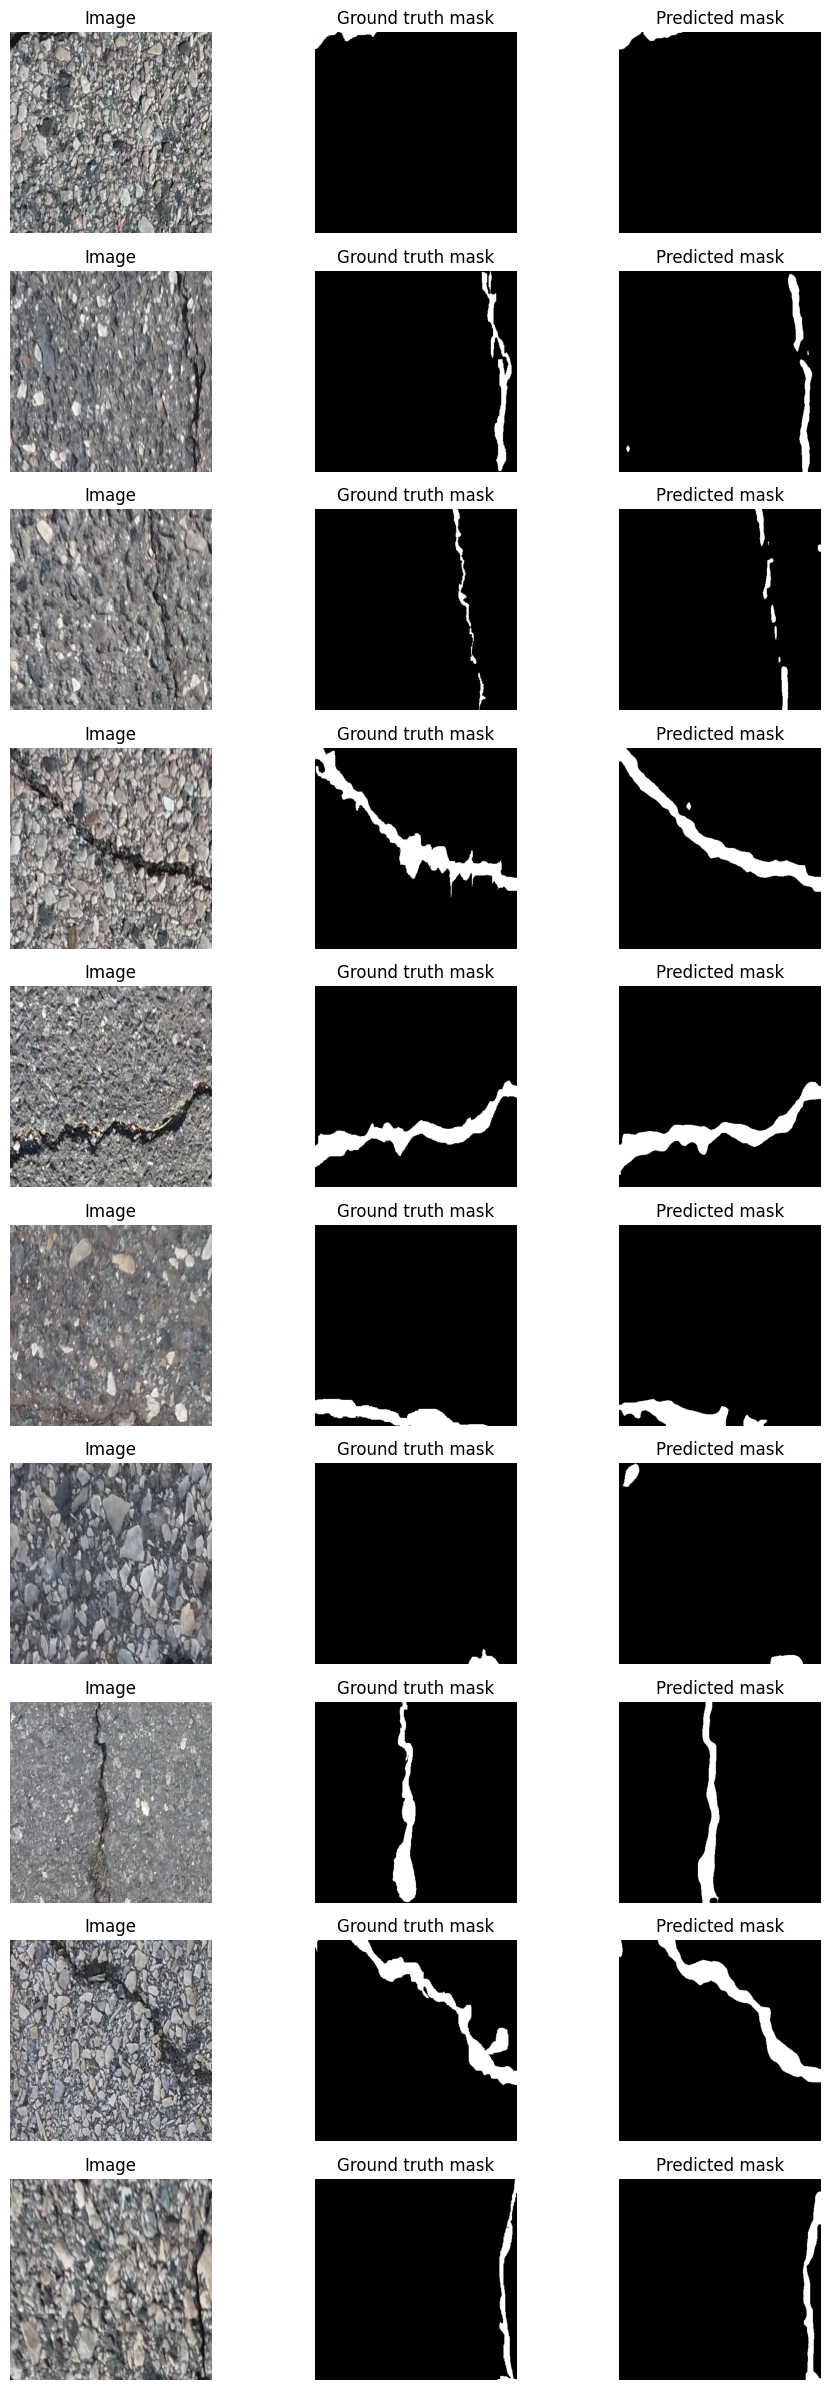

In [ ]:
# plot some examples of obtained segmentations
with torch.no_grad():
    predicted_masks = []
    for images, masks in test_dataloader:
        images = images.to(device)
        output = model(images)['out']
        predicted_masks.extend(output.argmax(1).cpu().numpy())

display_image_grid(test_list[:10], predicted_masks=predicted_masks)

How do both metrics (accuracy vs IoU) compare? Is one of them higher than the other? If so, why? Answer below.

ANSWER:

**Pixel accuracy** measures the proportion of correctly classified pixels (can be both foreground or background) in regards to the total number of pixels in the image. However, this metric is misleading, especially in situations of class imbalance. For example, if the background is much bigger, a model that simply classifies everything as background would have a high accuracy.   

**IoU, or Jaccard index**, measures the overlap between the predicted segmentation and the ground truth segmentation, indicating how well the prediction aligns with the ground truth. Because of this, it is more robust against class imbalance.

The images we are processing have great class imbalance (the background is much bigger than the foreground), meaning that the pixel accuracy metric will not be a good indicator of the performance of the segmentation.
Because of this, we can observe that pixel accuracy has significantly higher values than the IoU metric. (The high majority of pixels is background, and most of them are easy to label, so it has a higher value in terms of accuracy than in terms of IoU)

## Exercise 2

The dataset is clearly imbalanced, i.e. there are more background pixels than foreground pixels.

Is the cross entropy loss the best choice for this scenario?

Retrain your model using a loss that takes the class imbalance into account (e.g. Focal Loss). Take a look at the [PyTorch geometry](https://kornia.readthedocs.io/en/v0.1.2/losses.html) package for this purpose.

In [ ]:
### Write your code here ###
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms
from torch.optim import Adam
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

#CONFIRMAR
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()

        if self.reduction == 'none':
            return focal_loss
        elif self.reduction == 'mean':
            return focal_loss.mean()

# load pretrained model (do not forget to change the number of classes)
weights = models.segmentation.FCN_ResNet101_Weights.DEFAULT
model = models.segmentation.fcn_resnet101(weights=weights)

#changes to 2 classes: crack and no crack
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))

# put model in GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# define optimizer
optimizer = Adam(model.parameters(), learning_rate)

# define loss
criterion = FocalLoss(alpha=1, gamma=2)

# train the model
for epoch in range(epochs):
        model.train()
        for images, masks in train_dataloader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            output = model(images)['out']
            loss = criterion(output, masks)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# measure the performance of your model
def pixel_accuracy(output, mask):
    return (output.argmax(1) == mask).float().mean()

def iou(output, mask, num_classes):
    output = output.argmax(1).flatten()
    mask = mask.flatten()
    iou_score = jaccard_score(mask.cpu().numpy(), output.cpu().numpy(), average='macro', zero_division=0)
    return iou_score

model.eval()
with torch.no_grad():
    for images, masks in test_dataloader: #1 value of the metric for each batch of images, in a total of 7 batches
        images, masks = images.to(device), masks.to(device)
        output = model(images)['out']
        print(f"Pixel Accuracy: {pixel_accuracy(output, masks)}")
        print(f"IoU: {iou(output, masks, num_classes=2)}")


Epoch 1, Loss: 0.032604727894067764
Epoch 2, Loss: 0.020509734749794006
Epoch 3, Loss: 0.01601506397128105
Epoch 4, Loss: 0.01732497289776802
Epoch 5, Loss: 0.01491477619856596
Epoch 6, Loss: 0.01420787163078785
Epoch 7, Loss: 0.014356276951730251
Epoch 8, Loss: 0.017557960003614426
Epoch 9, Loss: 0.006743732839822769
Epoch 10, Loss: 0.00924241729080677
Pixel Accuracy: 0.9797369241714478
IoU: 0.7976103729431989
Pixel Accuracy: 0.9779874682426453
IoU: 0.7664099265866879
Pixel Accuracy: 0.9726506471633911
IoU: 0.7829175092302435
Pixel Accuracy: 0.9786333441734314
IoU: 0.8117932441807416
Pixel Accuracy: 0.961580216884613
IoU: 0.7753173754766421
Pixel Accuracy: 0.9527544379234314
IoU: 0.7175830268477805
Pixel Accuracy: 0.8814796805381775
IoU: 0.5914591467513375


Type of test_dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
Number of batches in test_dataloader: 7


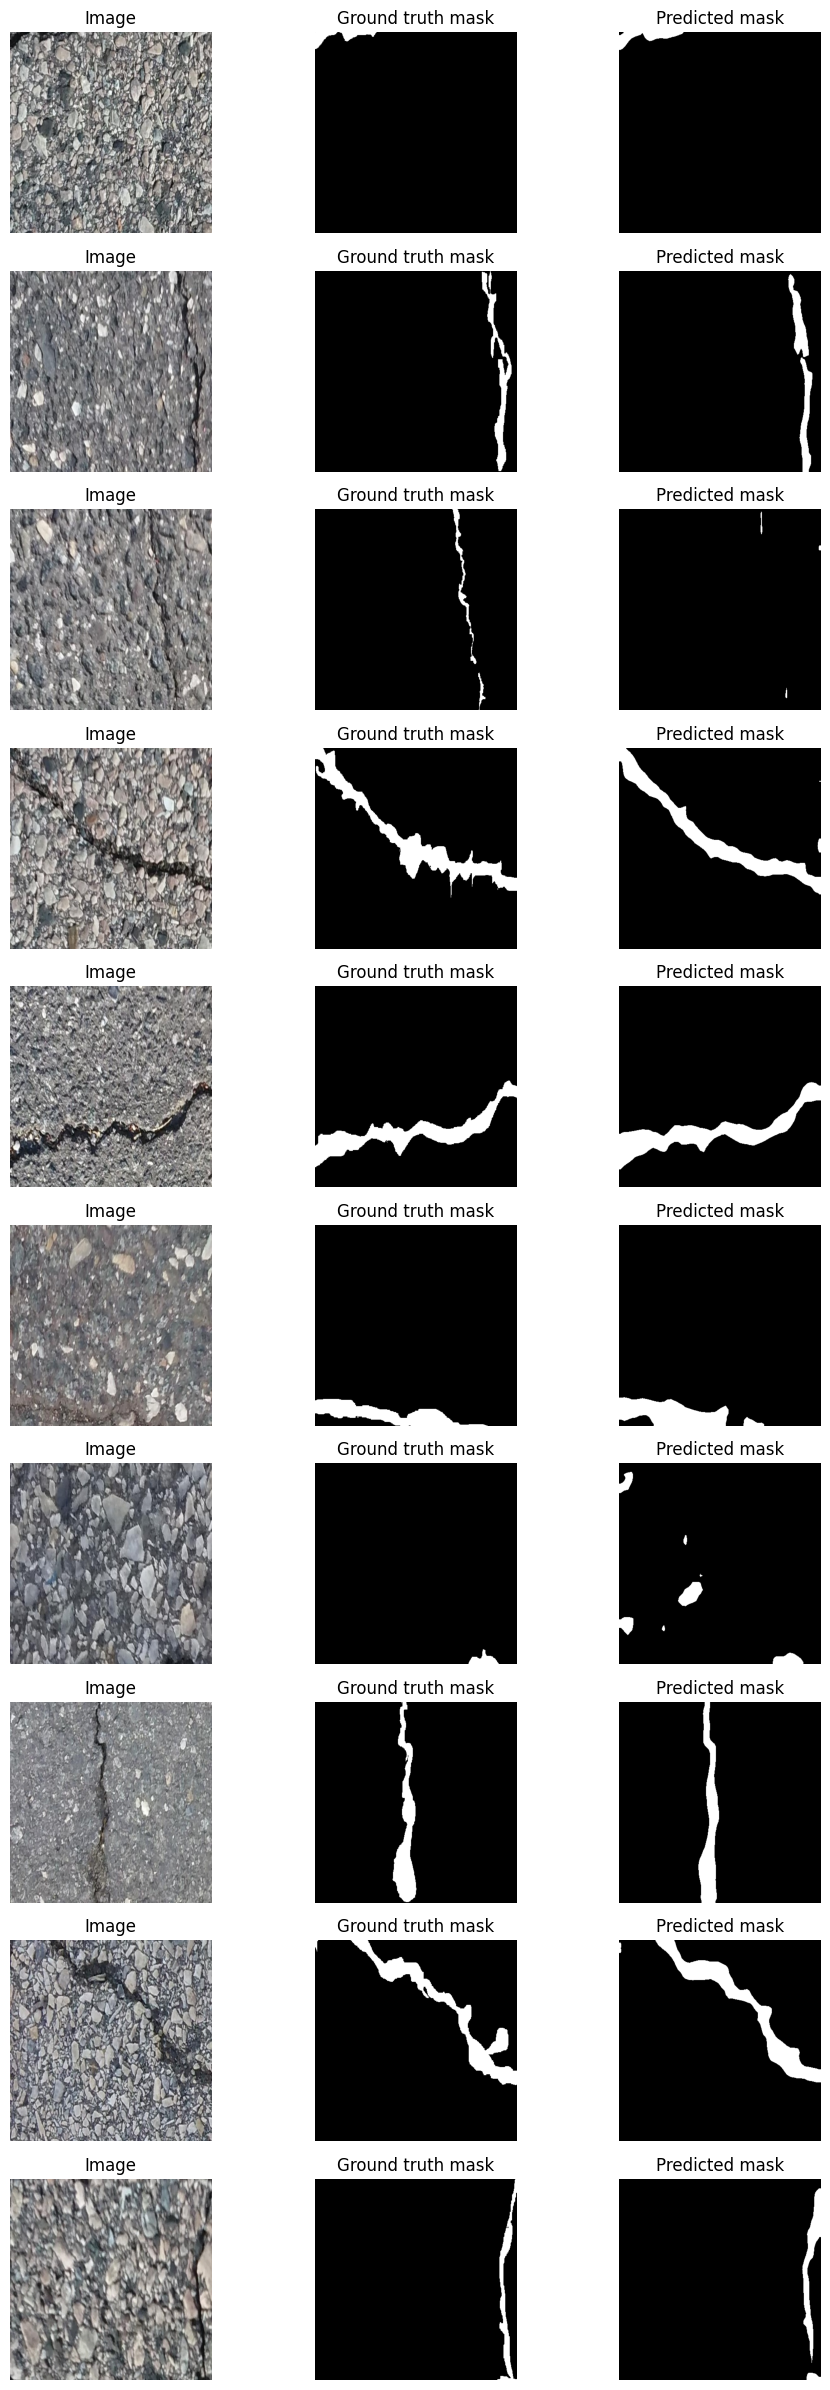

In [ ]:

# plot some examples of obtained segmentations
with torch.no_grad():
    predicted_masks = []
    for images, masks in test_dataloader:
        images = images.to(device)
        output = model(images)['out']
        predicted_masks.extend(output.argmax(1).cpu().numpy())

display_image_grid(test_list[:10], predicted_masks=predicted_masks)

Compare the performance of both models.

ANSWER:

**Cross-entropy loss** is a loss function that measures the different between the  predicted probability distribution of pixels belonging to a certain class and the true class labels of the image.

**Focal loss** is a loss function that takes class imbalance into account. It alters the cross-entropy loss, in order to down-weight the contributions of easy examples (examples with high confidence), so that the model focuses more on harder examples. This is especially relevant for images where the majority of pixels are background and the minority are objects or foreground, which is the case of this dataset.

Because of this, we expect the focal loss to perform better than cross-entropy loss.

Observing the results, the IoU metric has slightly higher values in only some of the image batches (3 out of the 7) for the segmentation using focal loss.
Additionally, comparing the images of the predicted mask of both types of segmentation, similar results can be seen, although focal loss seems to work a bit better overall in terms of false positives (with the exception of image 7).

However, this is a small dataset, so it is not possible to take conclusions on the performance. It is still very likely that focal loss may work better overall, for a model that is better trained or using different hyperparameters.